# Set up

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import cv2
import numpy as np
from skimage import transform as trans
import matplotlib.pyplot as plt

In [3]:
!pip install mtcnn
from mtcnn.mtcnn import MTCNN

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 18.9 MB/s eta 0:00:00


In [19]:
from keras.models import load_model
from imutils import paths
import numpy as np
import argparse
import pickle
import time
import cv2
import os

<hr>

# Prepare model

In [59]:
import pickle

In [60]:
embeddings = "/content/drive/MyDrive/coconut/outputs/embeddings_small_datasets.pickle"
le = "/content/drive/MyDrive/coconut/outputs/le.pickle"

In [61]:
with open(embeddings,"rb") as f:
    data = pickle.load(f)
# data
with open(le,"rb") as f:
    le = pickle.load(f)

In [62]:
embeddings = np.array(data['embeddings'])
labels = le.fit_transform(data['names'])         # แทนชื่อคนด้วยตัวเลข

In [63]:
labels

array([2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [64]:
detector = MTCNN()

In [65]:
! pip install onnxruntime
import onnxruntime as ort
import cv2
import numpy as np
import onnxruntime as ort

class FaceModel:
    def __init__(self, embedding_model_path):
        self.session = ort.InferenceSession(embedding_model_path)

    def preprocess_image(self, img_input):
        # Check if the input is a file path (string) or a NumPy array (image)
        if isinstance(img_input, str):  # If it's a file path
            img = cv2.imread(img_input)
            if img is None:
                raise ValueError(f"Image not found at path: {img_input}")
        elif isinstance(img_input, np.ndarray):  # If it's an image (NumPy array)
            img = img_input
        else:
            raise TypeError("Input must be a file path (str) or an image (np.ndarray)")

        # Resize the image to (112, 112)
        img = cv2.resize(img, (112, 112))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = np.transpose(img, (2, 0, 1)).astype(np.float32)
        img = img / 255.0
        img = np.expand_dims(img, axis=0)  # Add batch dimension
        return img

    def get_embedding(self, img):
        inputs = self.session.get_inputs()
        outputs = self.session.run(None, {inputs[0].name: img})
        embedding = outputs[0]
        return embedding[0]

In [66]:
# # Initialize faces embedding model
# embedding_model =face_model.FaceModel(args)
embedding_model_path = "/content/drive/MyDrive/coconut/buffalo_l/w600k_r50.onnx"
face_model = FaceModel(embedding_model_path)

In [67]:
# Load the classifier model
mymodel = "/content/drive/MyDrive/coconut/outputs/my_model.h5"
model = load_model(mymodel)

<hr>

# Comparing part

In [68]:
def findCosineDistance(vector1, vector2):
    vec1 = vector1.flatten()
    vec2 = vector2.flatten()

    a = np.dot(vec1.T,vec2)
    b = np.dot(vec1.T,vec1)
    c = np.dot(vec2.T,vec2)

    return 1 - (a/(np.sqrt(b)*np.sqrt(c)))
def CosineSimilarity(test_vec, source_vecs):
    cos_dist = 0
    for source_vec in source_vecs:
        cos_dist += findCosineDistance(test_vec, source_vec)
    return cos_dist/len(source_vecs)

In [69]:
# Setup some useful arguments
cosine_threshold = 0.8
proba_threshold  = 0.85
comparing_num    = 5

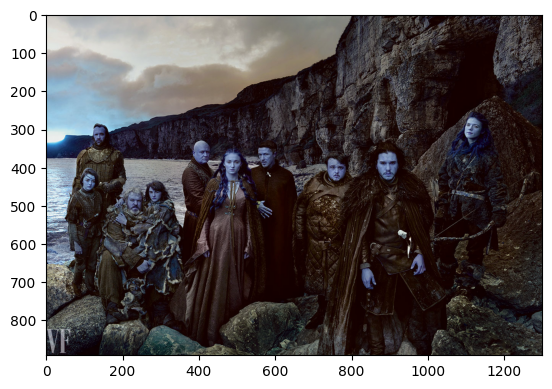

In [70]:
img = cv2.imread("/content/drive/MyDrive/coconut/small_datasets/test/001.jpg")
plt.imshow(img)

In [71]:
bboxes = detector.detect_faces(img)
bboxes

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 321ms/step


[{'box': [1099, 271, 42, 53],
  'confidence': 0.9999998211860657,
  'keypoints': {'left_eye': (1107, 290),
   'right_eye': (1126, 294),
   'nose': (1112, 300),
   'mouth_left': (1105, 311),
   'mouth_right': (1120, 313)}},
 {'box': [742, 383, 43, 53],
  'confidence': 0.999993622303009,
  'keypoints': {'left_eye': (752, 402),
   'right_eye': (772, 403),
   'nose': (761, 413),
   'mouth_left': (753, 425),
   'mouth_right': (768, 425)}},
 {'box': [98, 422, 29, 38],
  'confidence': 0.9999480843544006,
  'keypoints': {'left_eye': (109, 436),
   'right_eye': (123, 438),
   'nose': (116, 445),
   'mouth_left': (108, 451),
   'mouth_right': (119, 453)}},
 {'box': [393, 345, 36, 44],
  'confidence': 0.9999112486839294,
  'keypoints': {'left_eye': (409, 361),
   'right_eye': (425, 362),
   'nose': (421, 370),
   'mouth_left': (410, 379),
   'mouth_right': (424, 379)}},
 {'box': [868, 364, 53, 67],
  'confidence': 0.9999012351036072,
  'keypoints': {'left_eye': (883, 390),
   'right_eye': (908, 3

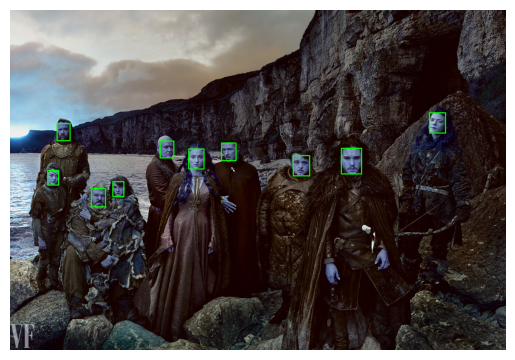

In [72]:
img_test = cv2.imread("/content/drive/MyDrive/coconut/small_datasets/test/001.jpg")
if len(bboxes) != 0:
    for bboxe in bboxes:
        # bbox = bboxe['box']
        # print(bbox)

        x, y, width, height = bboxe['box']
        cv2.rectangle(img_test, (x, y), (x+width, y+height), (0, 255, 0), 2)  # Green bounding box

    plt.imshow(img_test)
    plt.axis('off')  # Hide axes
    plt.show()

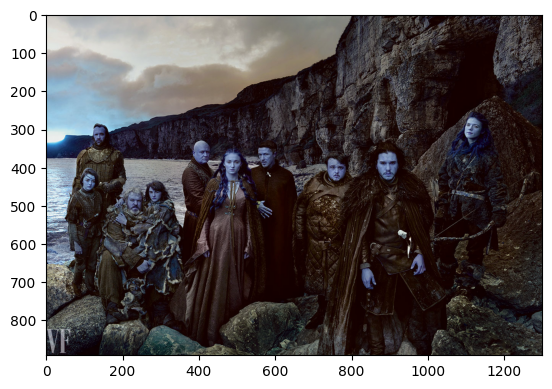

In [73]:
plt.imshow(img)

In [74]:
import cv2
import numpy as np
from skimage import transform as trans
import matplotlib.pyplot as plt
class FacePreprocessor:
    def __init__(self,image_size='112,112',margin=44):
        self.image_size = [int(x) for x in image_size.split(',')]
        if len(self.image_size) == 1:
            self.image_size = [self.image_size[0],self.image_size[0]]
        self.margin = margin
        assert len(self.image_size) == 2
        assert self.image_size[0] == 112 and (self.image_size[1] == 112 or self.image_size[1] == 96)
    def read_image(self,img_path,mode='rgb',layout='HWC'):
        if mode == 'gray': # gray -> gray
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        else:
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            if mode == 'rgb':
                img = img[..., ::-1]
            if layout == 'CHW':
                img = np.transpose(img,(2,0,1))
        return img
    def preprocess(self, img, bbox=None, landmark=None):
        if isinstance(img, str):
            img = self.read_image(img)

        M = None
        if landmark is not None:
            assert len(self.image_size) == 2
            src = np.array([
                [30.2946, 51.6963],
                [65.5318, 51.5014],
                [48.0252, 71.7366],
                [33.5493, 92.3655],
                [62.7299, 92.2041]], dtype=np.float32)

            if self.image_size[1] == 112:
                src[:, 0] += 8.0
            dst = landmark.astype(np.float32)

            tform = trans.SimilarityTransform()
            tform.estimate(dst, src)
            M = tform.params[0:2, :]

        if M is None:
            return self._center_crop(img, bbox)
        else:
            return self._warp_image(img, M)

    def _center_crop(self, img, bbox):
        if bbox is None:
            det = np.zeros(4, dtype=np.int32)
            det[0] = int(img.shape[1] * 0.0625)
            det[1] = int(img.shape[0] * 0.0625)
            det[2] = img.shape[1] - det[0]
            det[3] = img.shape[0] - det[1]
        else:
            det = bbox

        bb = np.zeros(4, dtype=np.int32)
        bb[0] = np.maximum(det[0] - self.margin // 2, 0)
        bb[1] = np.maximum(det[1] - self.margin // 2, 0)
        bb[2] = np.minimum(det[2] + self.margin // 2, img.shape[1])
        bb[3] = np.minimum(det[3] + self.margin // 2, img.shape[0])

        ret = img[bb[1]:bb[3], bb[0]:bb[2], :]
        if len(self.image_size) > 0:
            ret = cv2.resize(ret, (self.image_size[1], self.image_size[0]))
        return ret

    def _warp_image(self, img, M):
        assert len(self.image_size) == 2
        warped = cv2.warpAffine(img, M, (self.image_size[1], self.image_size[0]), borderValue=0.0)
        return warped


In [75]:
preprocessor = FacePreprocessor(image_size='112,112',margin=44)

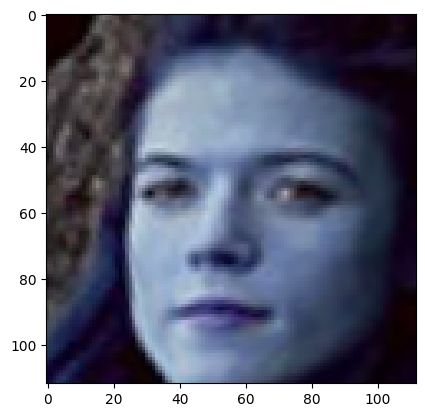

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
[9.9969018e-01 3.0968967e-04 1.1600605e-07]


In [83]:
if len(bboxes) != 0:
    for bboxe in bboxes:
        bbox = bboxe['box']
        bbox = np.array([bbox[0],bbox[1],bbox[0]+bbox[2],bbox[1]+bbox[3]])      # Frame ของหน้า
        landmarks = bboxe['keypoints']
        landmarks = np.array([                                                  # Extract landmark keypoint
            landmarks["left_eye"][0],
            landmarks["right_eye"][0],
            landmarks["nose"][0],
            landmarks["mouth_left"][0],
            landmarks["mouth_right"][0],
            landmarks["left_eye"][1],
            landmarks["right_eye"][1],
            landmarks["nose"][1],
            landmarks["mouth_left"][1],
            landmarks["mouth_right"][1]
        ])
        # print(landmarks)
        landmarks = landmarks.reshape((2,5)).T
        # print(landmarks)
        nimg = preprocessor.preprocess(img,bbox,landmarks)                      # ได้หน้าของแต่ละคน
        plt.imshow(nimg)
        plt.show()
        prep_img = face_model.preprocess_image(nimg)
        # img -> Embedding vector
        embedding = face_model.get_embedding(prep_img).reshape(1,-1)
        # print(embedding)

        text = "Unknown"

        # Predict class
        preds = model.predict(embedding)                                        # [[9.9969018e-01 3.0968967e-04 1.1600605e-07]]
        preds = preds.flatten()                                                 # [9.9969018e-01 3.0968967e-04 1.1600605e-07]
        print(preds)

        break

In [99]:
j = np.argmax(preds)                                                            # 0,1,2 class ที่มากสุด
proba = preds[j]                                                                # เอาเปอร์เซ้นของตัวที่มากที่สุดมา
match_class_idx = labels == j


In [100]:
match_class_idx

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [101]:
match_class_idx = np.where(match_class_idx)[0]
match_class_idx

array([16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
       50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64])

In [114]:
selected_idx = np.random.choice(match_class_idx, 10)
selected_idx

array([20, 30, 35, 33, 25, 43, 33, 61, 48, 36])

In [115]:
compare_embeddings = embeddings[selected_idx]
compare_embeddings

array([[ 0.47931874,  0.41138273,  1.833725  , ..., -1.4554629 ,
         0.441642  ,  0.73891383],
       [-1.2351431 ,  2.1181362 ,  0.8030308 , ...,  0.7551193 ,
        -0.02226987, -1.1294738 ],
       [-0.28346246, -0.0055898 ,  1.1199783 , ..., -0.53716993,
        -1.1272455 ,  0.87019277],
       ...,
       [-1.081957  ,  1.2416236 ,  1.5094337 , ...,  0.18280435,
         0.10591333, -0.03322802],
       [-1.1201816 ,  1.5778618 ,  2.227045  , ...,  0.3241232 ,
         0.03178532,  0.07373816],
       [-0.64270055,  0.33832645,  1.2012466 , ..., -0.94300026,
        -0.62170905,  0.72159106]], dtype=float32)

In [117]:
cos_similarity = CosineSimilarity(embedding, compare_embeddings)
cos_similarity

0.9364317831989866

In [124]:
cosine_threshold = 1 #0.8
proba_threshold = 0 #0.85

In [125]:
if cos_similarity < cosine_threshold and proba > proba_threshold:
    name = le.classes_[j]
    text = "{}".format(name)
    print("Recognized: {} <{:.2f}>".format(name, proba*100))

Recognized: Arya Stark <99.97>
